# Final correlation analysis - TRAF2 Inhibitors 2 + 5

In [2]:
%matplotlib inline
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns

***
## Introduction
We predicted several TRAF2 inhibitors, ten of which were tested, and two of which showed reproducible inhibition of the canonical NFkB pathway. These hits, cpds 2 and 5, are listed below, along with three negative controls (cpds 6, 11, & 9). In this document we will compare the perturbational mRNA signatures of these five cpds to the knockdown signatures of TRAF2 and the proteins involved in the canonical NFkB pathway

In [3]:
# negative controls, cpds 6, 11, & 9
cntrl_cpds = ['BRD-K91047982','BRD-K60762818','BRD-K35687265']
# hits - cpds 2 & 5
hit_cpds = ['BRD-K95352812','BRD-A09719808']

***
First, we need to read in the complete dataset of consensus mRNA signatures from the LINCS L1000 experiments. A consensus mRNA signature is essentially a weighted average mRNA profile of a particular perturbagen (drug, knockdown, etc...) taken accross multiple experiments (often in multiple cell lines).

We acquired the consensus signature dataset from (https://github.com/dhimmel/lincs/), which we here load into a Pandas DataFrame (below). The dataframe has 978 rows, each representing a landmark gene whos expression was measured in the LINCS experiments. The ~40,000 columns represent unique perturbagens, including bioactive compounds, gene knockdowns, and gene overexpressions. 

In [12]:
consensi_df = pd.DataFrame.from_csv('consensi-pert_id.tsv', sep='\t', header=0).T
cntrl_cpd_signatures = consensi_df[cntrl_cpds]
hit_cpd_signatures = consensi_df[hit_cpds]
all_cpd_signatures = pd.concat([hit_cpd_signatures, cntrl_cpd_signatures], axis=1)

***
## mRNA perturbation: Z-score distributions

The first thing we can do is look at the mRNA signatures themselves: how do these compounds affect gene expression in the cell overall? Below we plot the Z-score distributions for the different compounds. As we can see, all five distributions center around zero, but compounds 2 & 5 produce much wider distributions, meaning that cpds 2 & 5 tend to up-regulate and down-regulate more genes.

The means and standard deviations of the distributions are shown below, along with the plots.

                   Mean   Std Dev
perturbagen                      
BRD-K95352812 -0.282761  3.553105
BRD-A09719808 -0.330593  3.676701
BRD-K91047982  0.037092  1.174678
BRD-K60762818  0.064209  1.458907
BRD-K35687265  0.047756  2.225955


<IPython.core.display.Javascript object>


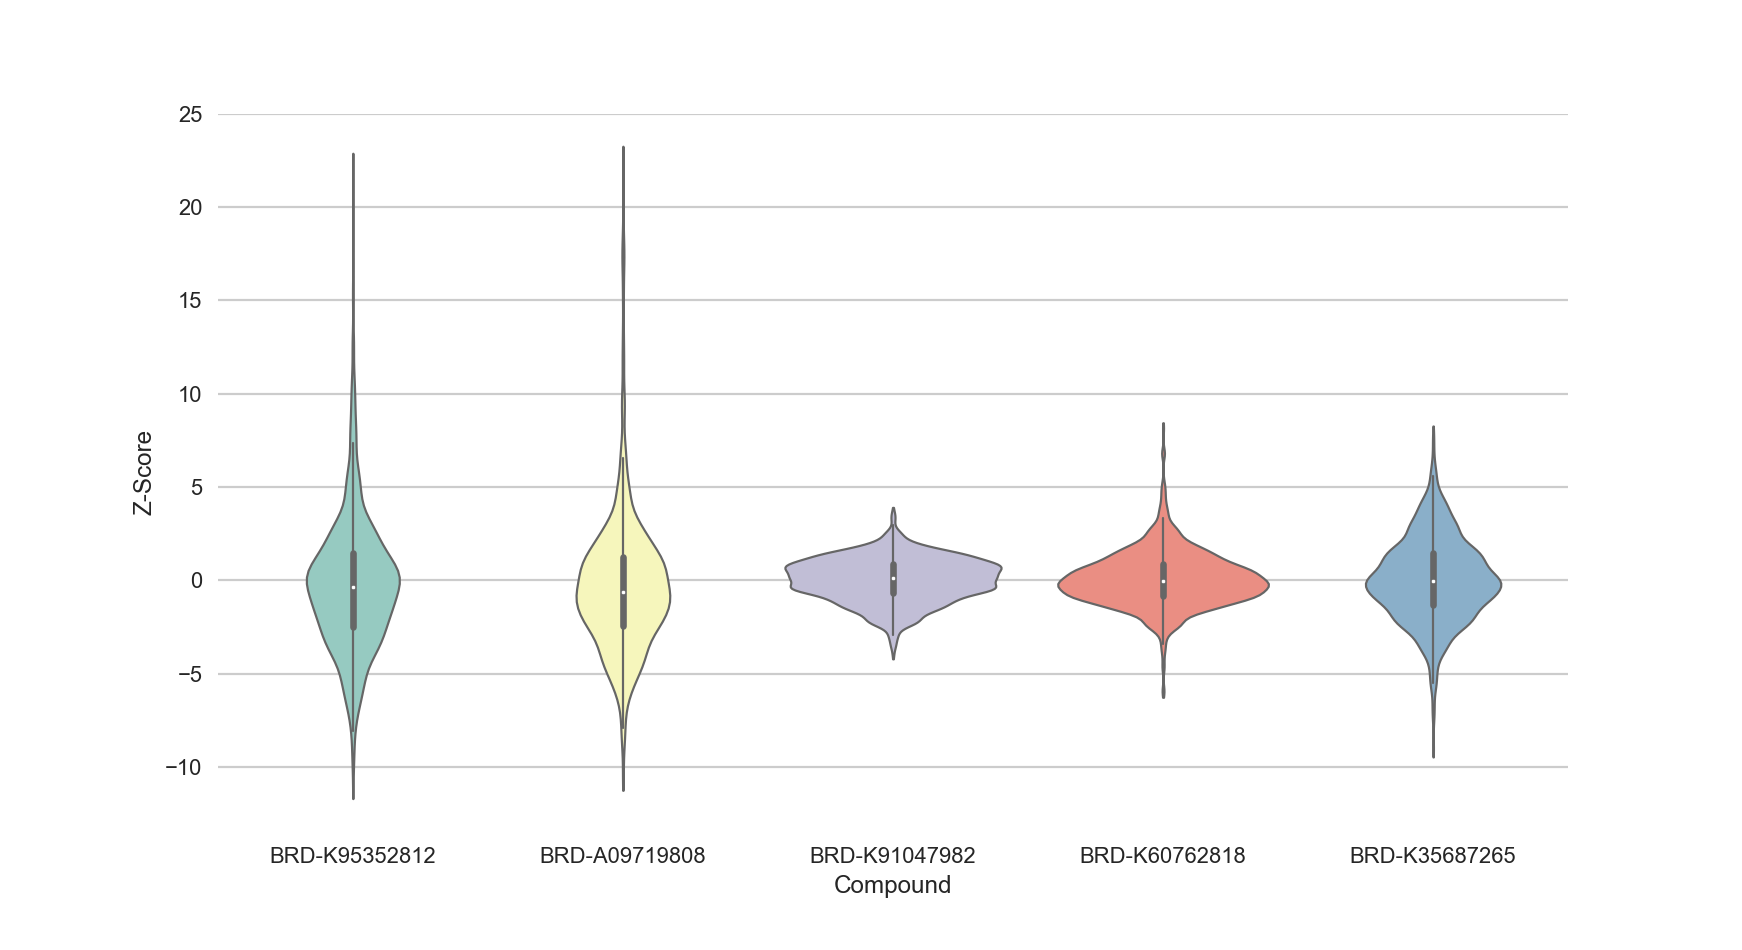

/Users/Nico/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


In [28]:
d = { 'Mean': np.mean(all_cpd_signatures), 'Std Dev' :  np.std(all_cpd_signatures) }
print(pd.DataFrame(d))

sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(11, 6))
sns.violinplot(all_cpd_signatures, palette="Set3", bw=.2, cut=1, linewidth=1)
#ax.set(ylim=(-.7, 1.05))
plt.ylabel("Z-Score")
plt.xlabel("Compound")
sns.despine(left=True, bottom=True)

***
## Cpd - cpd correlations in mRNA signatures

We can further compare the five Z-score distributions by computing their pairwise pearson correlations. Do these compounds tend to up/down regulate the same genes? To what degree do their transcriptional perturbations match each other?

As we can see from the heatmap below, cpds 2 and 5 produce highly correlated transcriptional perturbations. This makes sense, as we predict these two compounds to target the same protein. No other pairs of compounds produce significantly correlated signatures.

<IPython.core.display.Javascript object>


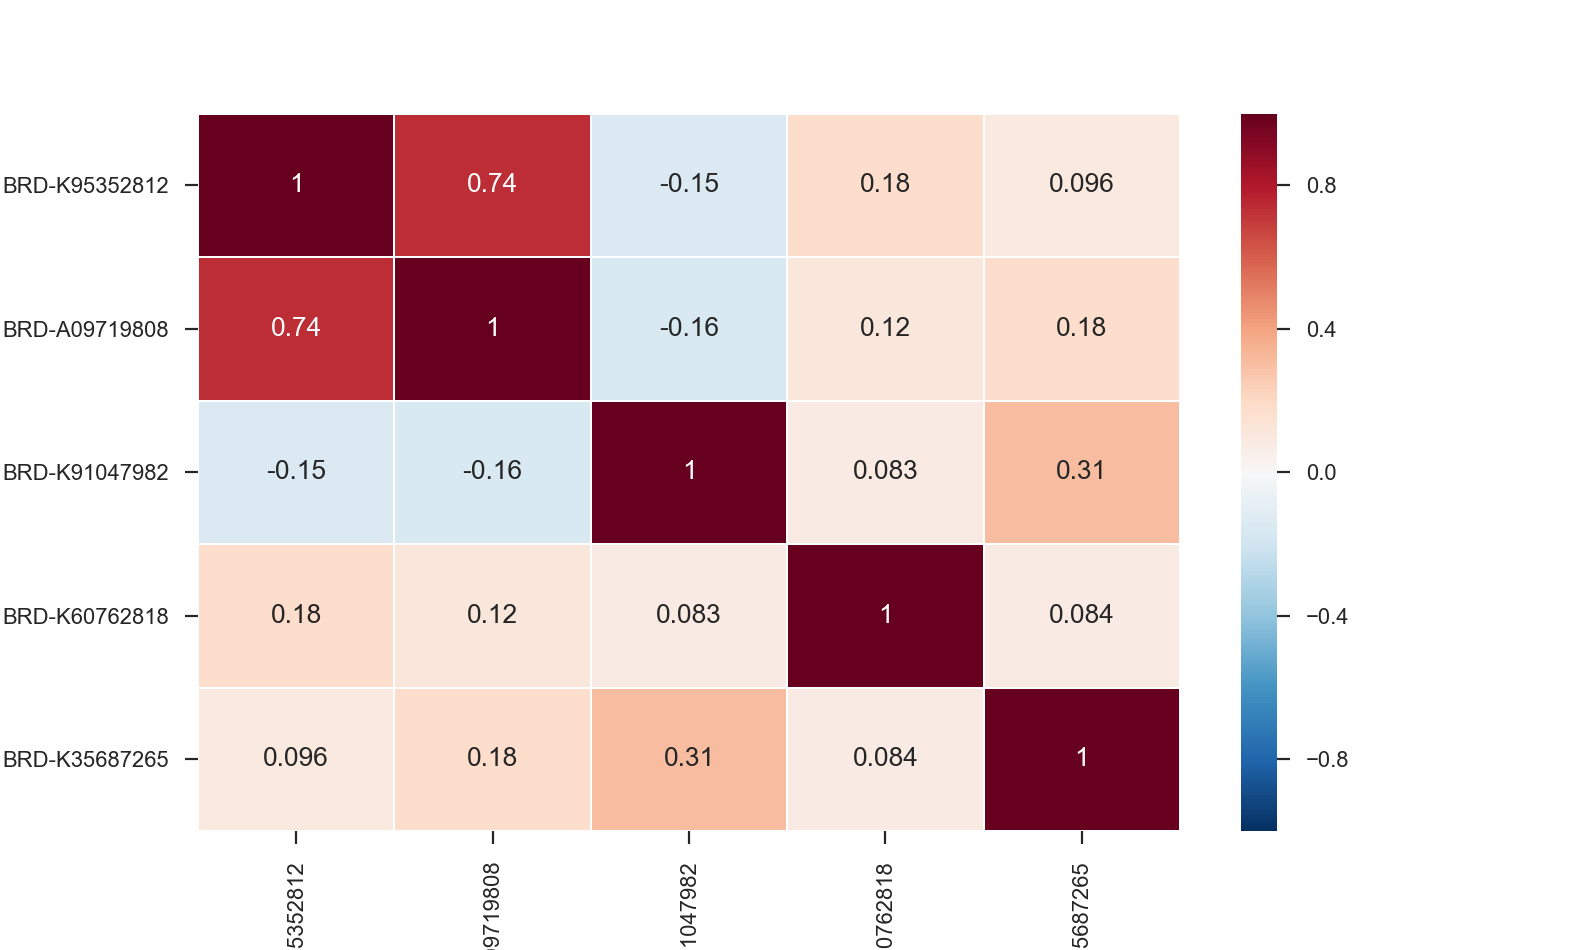

(array([ 0.5,  1.5,  2.5,  3.5,  4.5]), <a list of 5 Text yticklabel objects>)

In [47]:
cpd_cpd_corrs = all_cpd_signatures.corr()
f, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cpd_cpd_corrs, annot=True, linewidths=.5, ax=ax)
plt.xticks(rotation=90)
plt.yticks(rotation=0)

To get a different feel for this data, we can plot the pairwise mRNA profiles. Each row/column in the grid below represents a different compound. Each point on the plots represents one of the 978 landmark genes measured in the LINCS L1000 assays. Once again, we can see that cpds 2 and 5 are the only ones that show noticable correlation in their distributions.

<IPython.core.display.Javascript object>


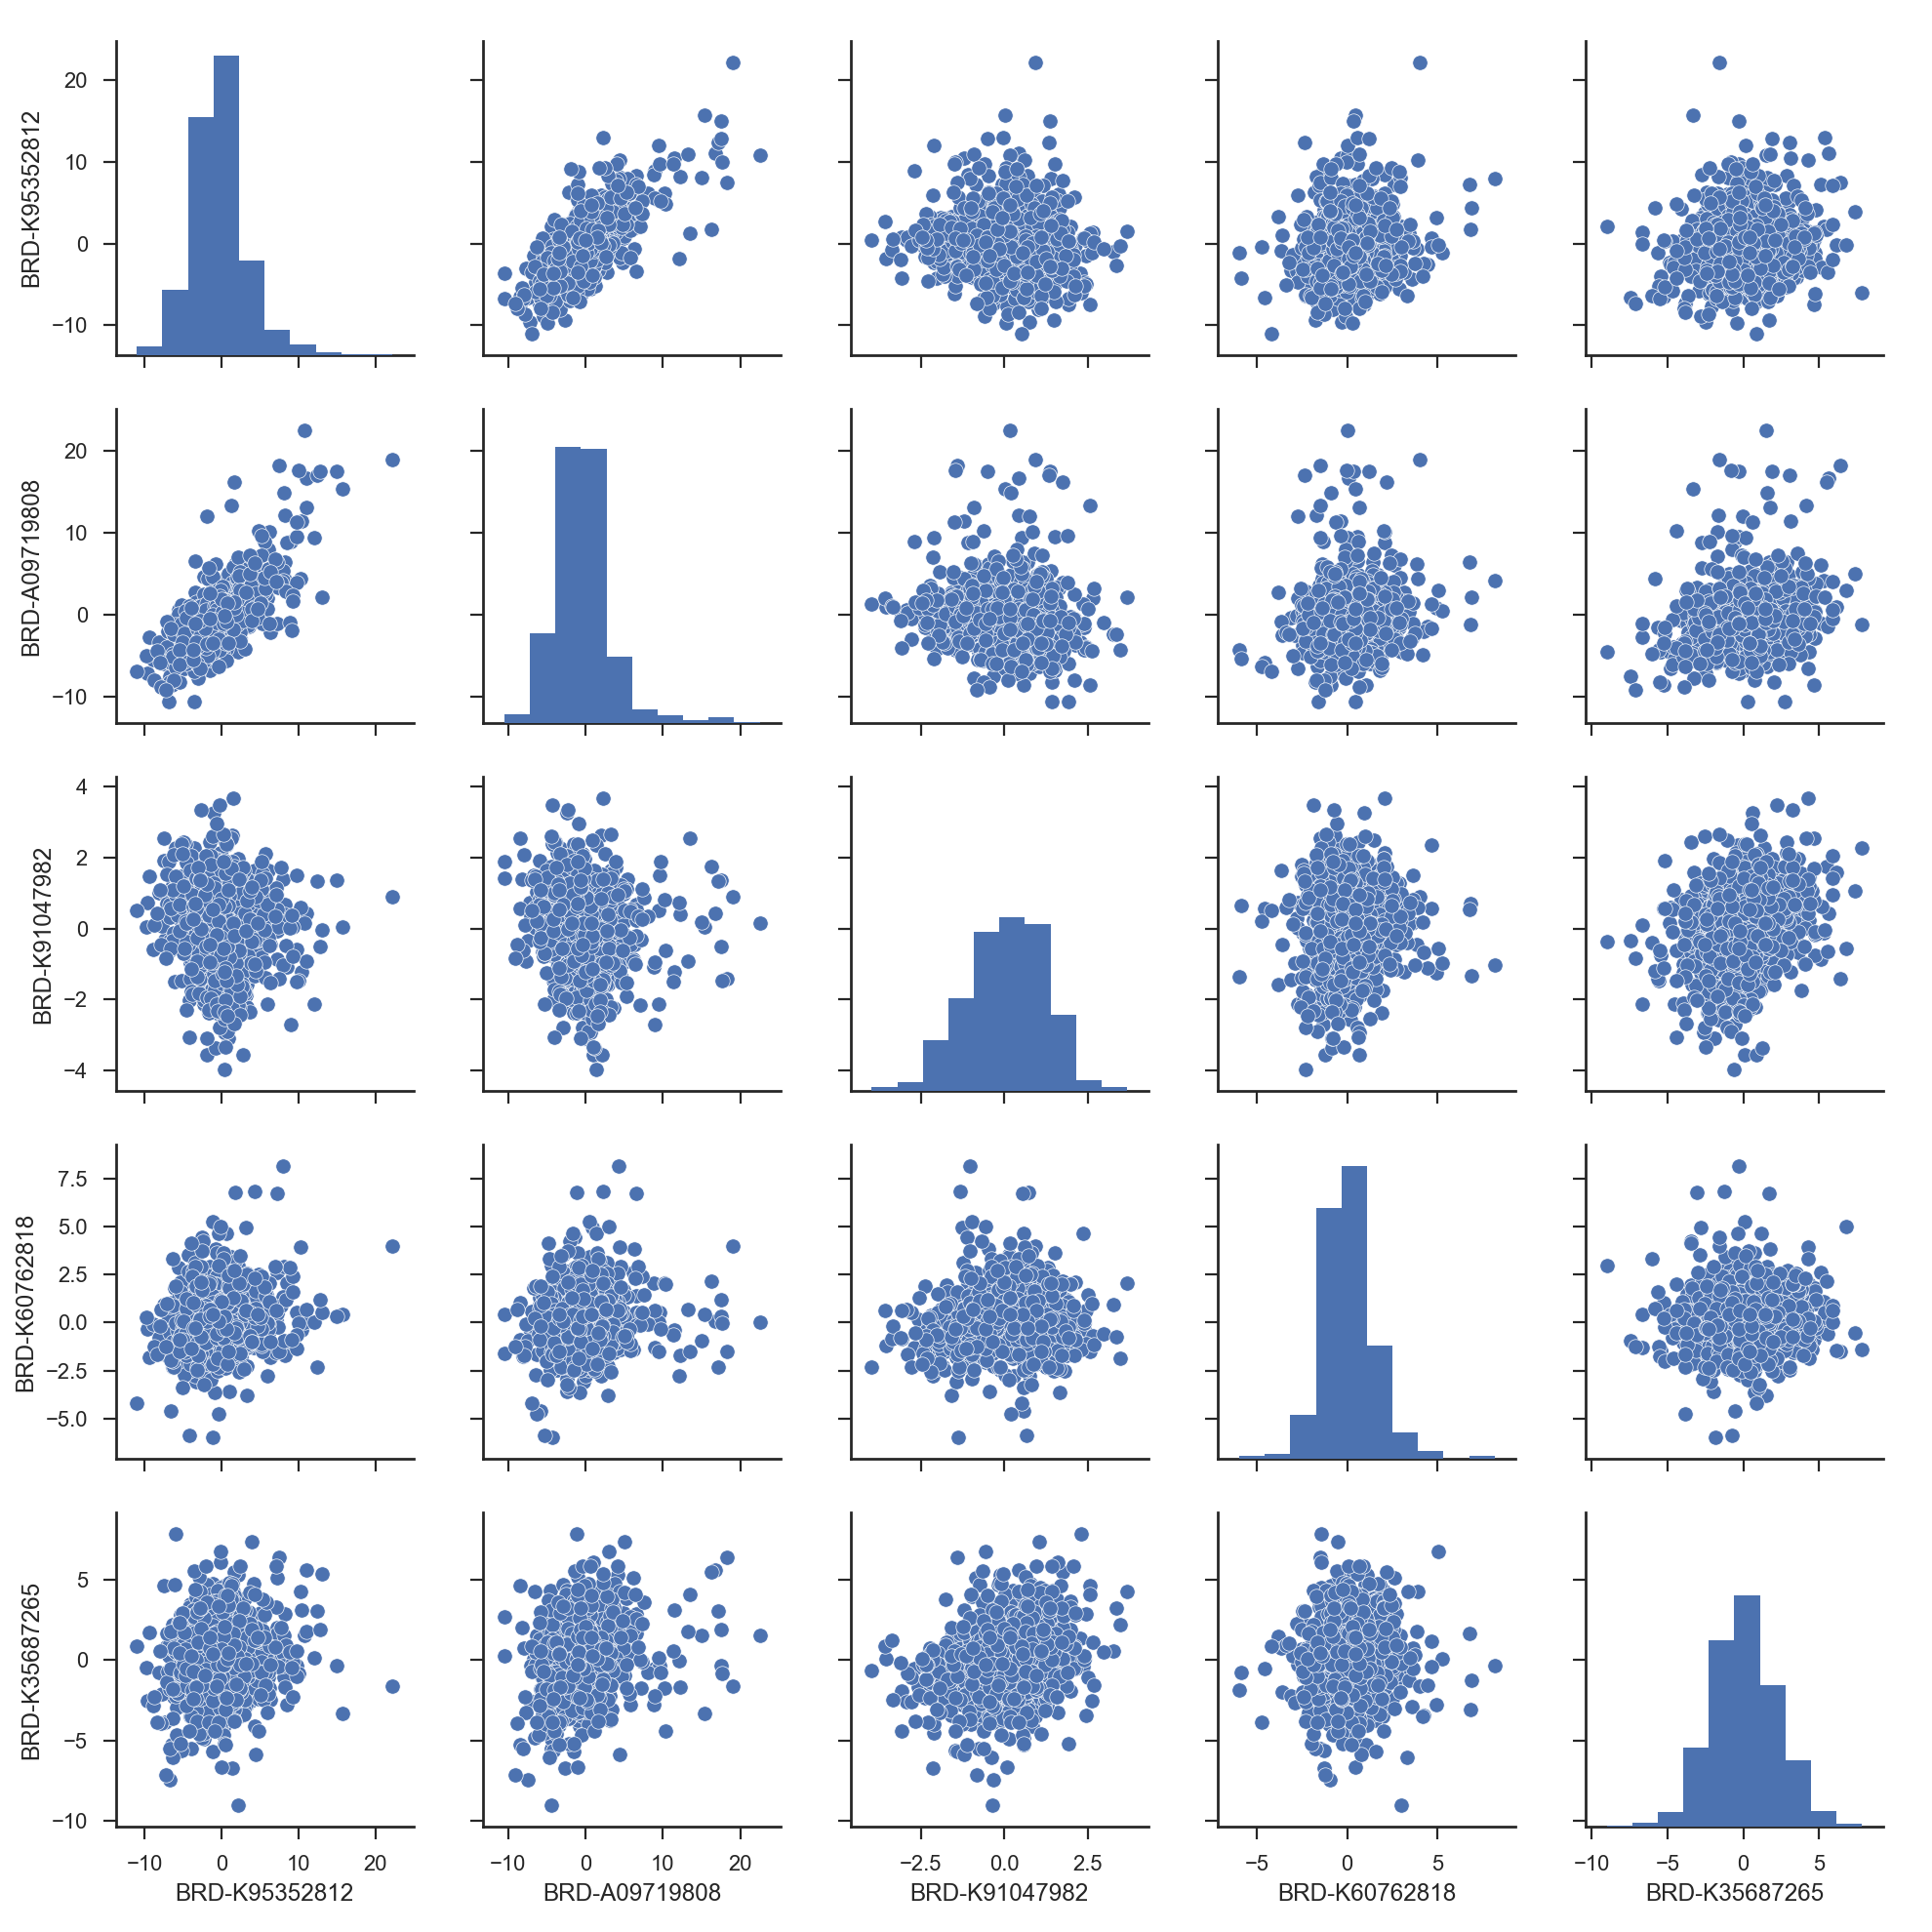

In [40]:
sns.set(style="ticks")
sns.pairplot(all_cpd_signatures)

***
## Cpd - knockdown correlations in mRNA signatures

The next question we will ask is whether the transcriptional pertubations produced by these five compounds correlate with the knockdowns of genes known to interact with TRAF2. If our compounds are indeed TRAF2 inhibitors, we would expect similar mRNA expression resulting from treatment with the inhibitor and knockdown of TRAF2 or its interaction partners.

First, we extract a list proteins that interact with TRAF2 from the BioGrid Database. Then we cross-reference these genes with the list of knockdowns performed in the LINCS L1000 assays. Ultimately we find transcriptional signatures from knockdowns of 142 different TRAF2 interaction partners. This includes genes from the canonical NFkB pathway as well as other pathways that TRAF2 is involved with.

In [55]:
# extract TRAF2 interaction partners from Biogrid.
Biogrid_df = pd.DataFrame.from_csv('BIOGRID-GENE-113038-3.4.153.tab2.txt', sep='\t', header=0)
TRAF2_partners = set(Biogrid_df[['Official Symbol Interactor A','Official Symbol Interactor B']].values.flatten())

# read in the LINCS knockdown dataset
KD_consensi_df = pd.DataFrame.from_csv('KD_consensus_sigs.csv', header=0).T
# not all the TRAF2 partners have KD data, so take the union of the two gene sets
LINCS_partner_genes = set(KD_consensi_df.columns) & TRAF2_partners
TRAF2_partner_signatures = KD_consensi_df[list(LINCS_partner_genes)]

# construct a new matrix with the cpd-partner correlations
corr_dict = {}
for cpd in all_cpd_signatures: 
    cpd_sig = all_cpd_signatures[cpd]
    corr_dict[cpd] = TRAF2_partner_signatures.corrwith(cpd_sig)
cpd_partner_corrs = pd.DataFrame(corr_dict)

***
Below we plot the distribution of Pearson correlation values for our five compound mRNA signatures compared against the 142 knockdown signatures from TRAF2 interactions partners. The means and standard deviations of the distributions are also shown. 

As we can see, cpds 2 (BRD-K95352812) and 5 (BRD-A09719808) show higher mean correlations with TRAF2 interaction partner knockdowns than our three control compounds.

                   Mean   Std Dev
BRD-A09719808  0.167115  0.181437
BRD-K35687265  0.078152  0.114517
BRD-K60762818  0.114349  0.071955
BRD-K91047982  0.025000  0.258197
BRD-K95352812  0.158425  0.170126


<IPython.core.display.Javascript object>


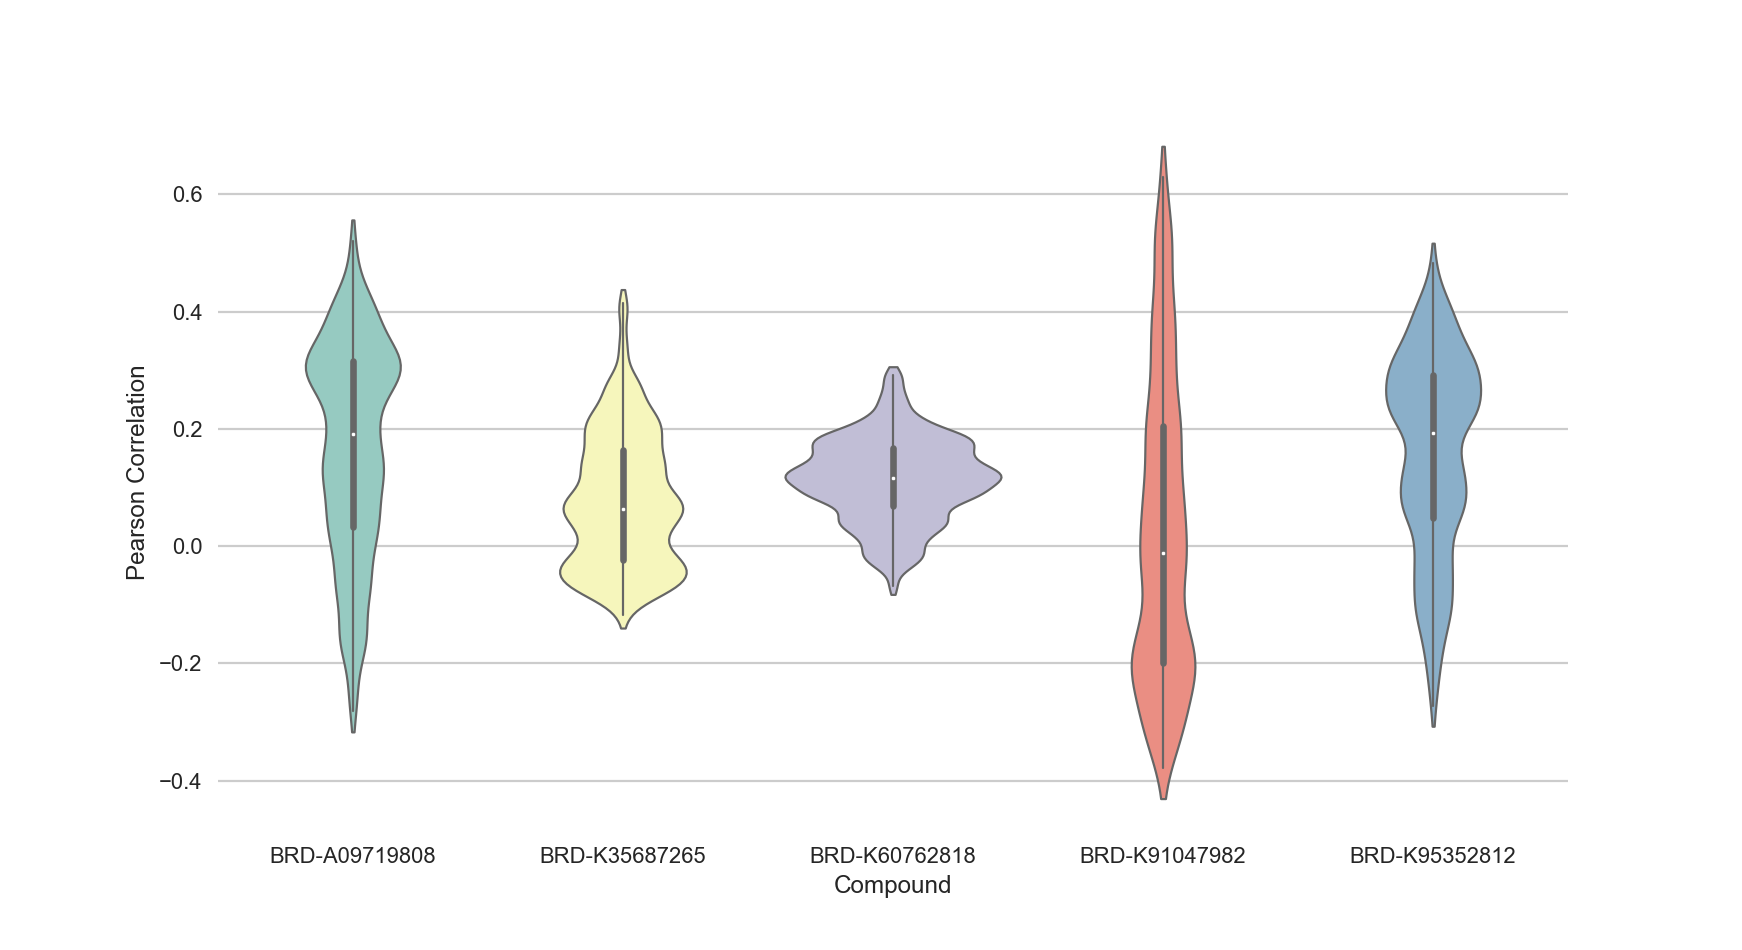

/Users/Nico/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


In [54]:
d = { 'Mean': np.mean(cpd_partner_corrs), 'Std Dev' :  np.std(cpd_partner_corrs) }
print(pd.DataFrame(d))

sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(11, 6))
sns.violinplot(cpd_partner_corrs, palette="Set3", bw=.2, cut=1, linewidth=1)
#ax.set(ylim=(-.7, 1.05))
plt.ylabel("Pearson Correlation")
plt.xlabel("Compound")
sns.despine(left=True, bottom=True)

The knockdowns with which each compound correlates and those with which it does not correlate can be thought of as a different type of 'signature' for the compound - a correlation signature. We can compute the pairwise correlations between these signatures to see which compounds tend to mimic the same sets of knockdowns. 

As can be seen in the heatmap below, our two hits tend to correlate with the same sets of knockdowns (correlations of 0.97), while our three controls seem to loosely correlate with a different set of knockdowns.

<IPython.core.display.Javascript object>


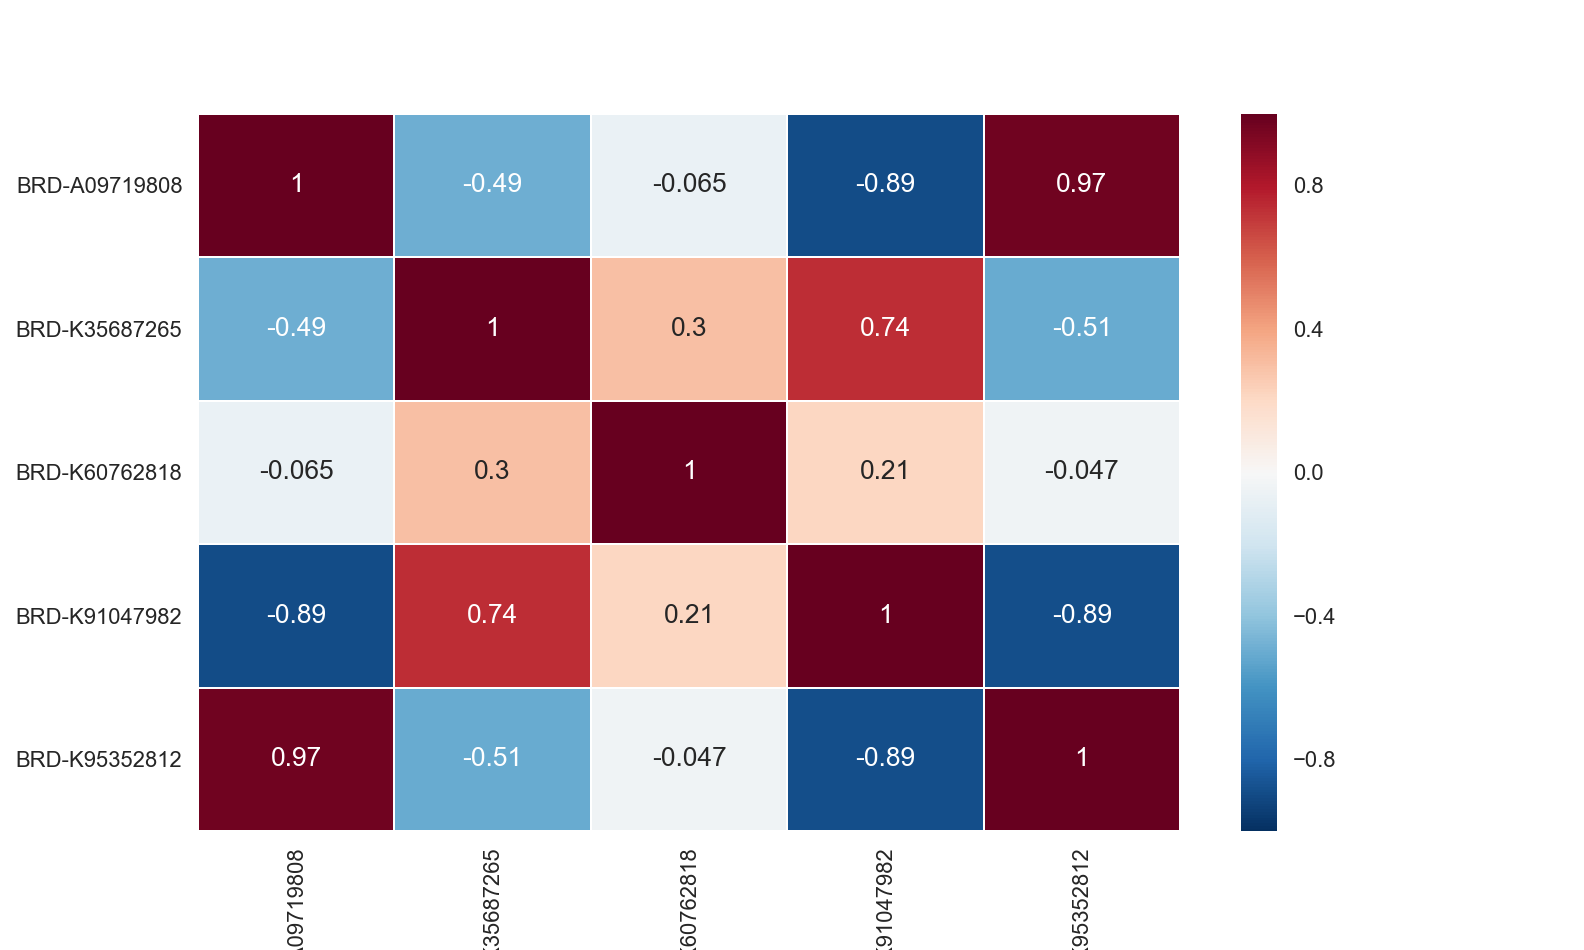

(array([ 0.5,  1.5,  2.5,  3.5,  4.5]), <a list of 5 Text yticklabel objects>)

In [57]:
cpd_partner_corr_corrs = cpd_partner_corrs.corr()
f, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(cpd_partner_corr_corrs, annot=True, linewidths=.5, ax=ax)
plt.xticks(rotation=90)
plt.yticks(rotation=0)

***
## Correlations within the canonical NFkB pathway

We can now narrow our focus to the genes in the canonical NFkB pathway that have been profiled in LINCS. The list of these genes is below. Once again we can compute correlation distributions as well as correlation heatmaps. 

We observe much the same results as above, with cpds 2 & 5 producing higher-than average correlations with knockdowns in the NFkB pathway, and tending to correlate with the same sets of knockdowns.

                   Mean   Std Dev
BRD-A09719808  0.191904  0.207516
BRD-K35687265  0.085927  0.131929
BRD-K60762818  0.098308  0.074145
BRD-K91047982 -0.000603  0.269582
BRD-K95352812  0.183612  0.183186


<IPython.core.display.Javascript object>


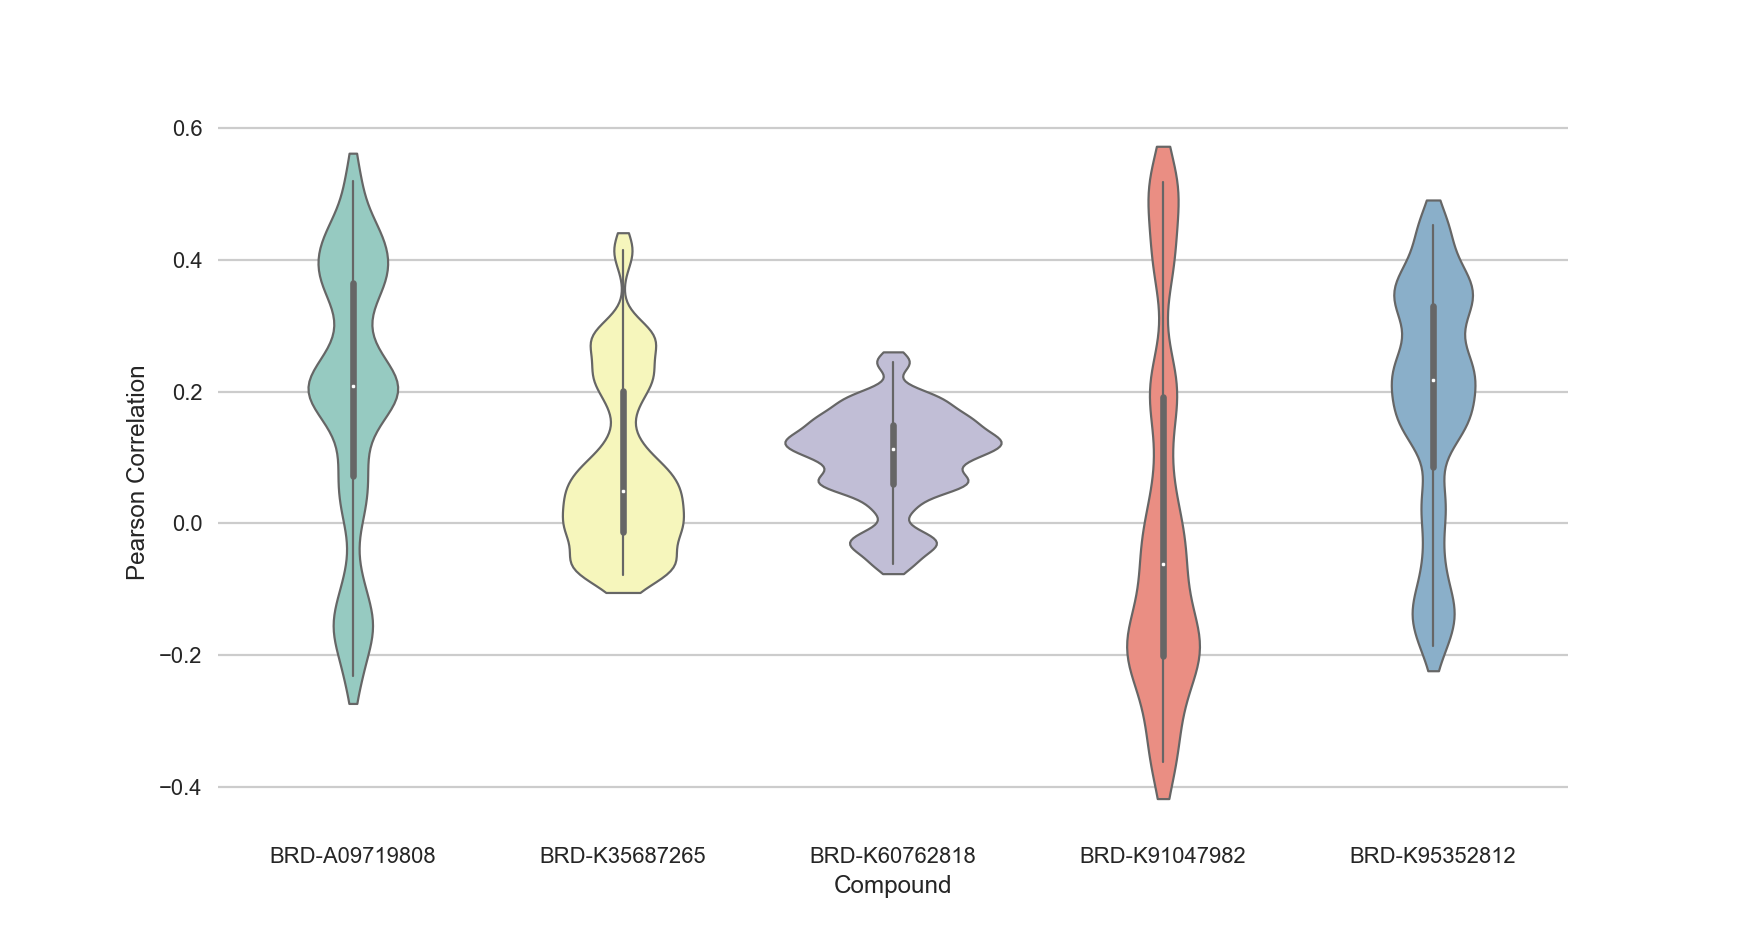

/Users/Nico/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:2342: UserWarning: The violinplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


<IPython.core.display.Javascript object>


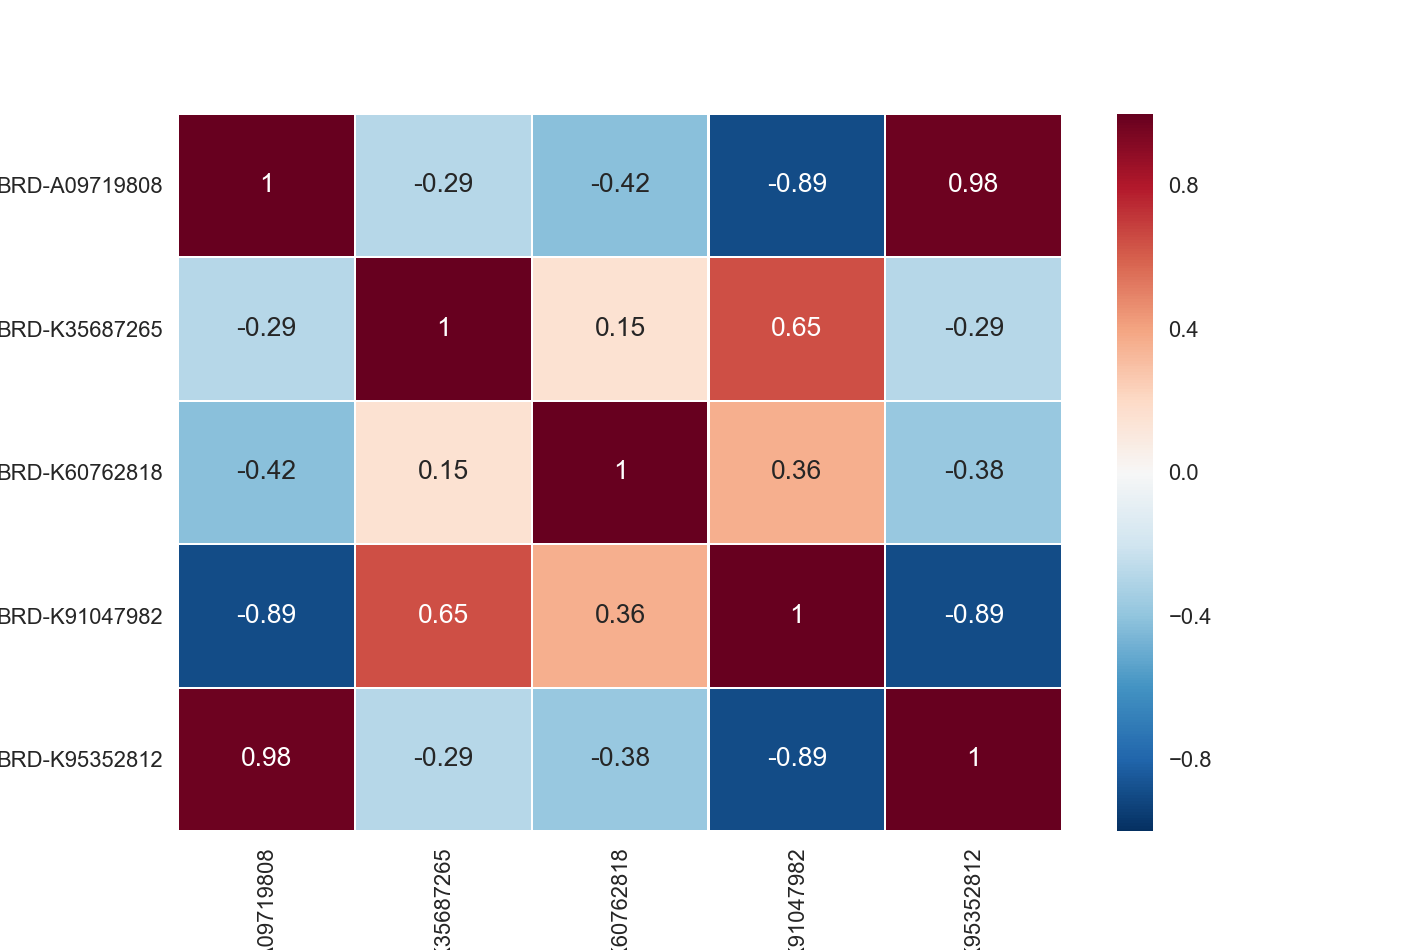

(array([ 0.5,  1.5,  2.5,  3.5,  4.5]), <a list of 5 Text xticklabel objects>)

In [63]:
NFkB_pathway=['TRAF2','TRAF5','TRAF6','TNFRSF1A','TRADD','RIPK1','UBE2D1','BIRC2','BIRC3','UBB','UBC','UBA52','RPS27A','TAB2','TAB3','MAP3K7','IKBKG','RBCK1','CHUK','IKBKB','RELA','RELB','NFKBIA','NFKB1','NFKB2','CYLD','TNFAIP3']
NFkB_signatures = KD_consensi_df[NFkB_pathway]

cpd_NFkB_corrs_d = {}
for cpd in all_cpd_signatures:
    cpd_sig = all_cpd_signatures[cpd]
    cpd_NFkB_corrs_d[cpd] = NFkB_signatures.corrwith(cpd_sig)
cpd_NFkB_corrs = pd.DataFrame(cpd_NFkB_corrs_d)

d = { 'Mean': np.mean(cpd_NFkB_corrs), 'Std Dev' :  np.std(cpd_NFkB_corrs) }
print(pd.DataFrame(d))

sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(11, 6))
sns.violinplot(cpd_NFkB_corrs, palette="Set3", bw=.2, cut=1, linewidth=1)
#ax.set(ylim=(-.7, 1.05))
plt.ylabel("Pearson Correlation")
plt.xlabel("Compound")
sns.despine(left=True, bottom=True)


cpd_NFkB_corr_corrs = cpd_NFkB_corrs.corr()
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(cpd_NFkB_corr_matrix, annot=True, linewidths=.5, ax=ax)
plt.yticks(rotation=0)
plt.xticks(rotation=90)

***
## Most highly correlated knockdowns 

The last thing we will look at is which knockdowns in the NFkB pathway our compounds correlate with the most and the least. As can be seen in the sorted table below, cpds 2 & 5 both correlate most highly with **UBC, UBB, RBCK1, UBE2D1**, and **RIPK1**. The correlate the least with **TRAF2, CHUK, CYLD**, and **RELA**.

In [102]:
cpd_dict = {}
for cpd in cpd_NFkB_corrs:
    cpd_sig = cpd_NFkB_corrs[cpd]
    cpd_d = { 'gene' : cpd_sig.index.values, 'corr' : cpd_sig.values }
    cpd_df = pd.DataFrame(cpd_d)
    cpd_df.sort_values('corr', ascending=False, inplace=True)
    cpd_df = cpd_df.reset_index()
    cpd_dict[(cpd, 'gene')] = cpd_df['gene']
    cpd_dict[(cpd, 'corr')] = cpd_df['corr']
pd.DataFrame(cpd_dict)

BRD-A09719808           BRD-K35687265           BRD-K60762818            \
            corr      gene          corr      gene          corr      gene   
0       0.520176       UBC      0.414769     TRAF6      0.245503      CHUK   
1       0.448156       UBB      0.287652     NFKB1      0.195074     TRAF2   
2       0.435528    UBE2D1      0.281922     TRADD      0.188758     TRAF6   
3       0.431772     RBCK1      0.280113     UBA52      0.176993      RELA   
4       0.396465    RPS27A      0.242854     TRAF2      0.160785     NFKB2   
5       0.395371     RIPK1      0.219775      CHUK      0.159653    UBE2D1   
6       0.371724      TAB2      0.219480      CYLD      0.156614      TAB2   
7       0.357790     TRAF5      0.181338     BIRC2      0.141287     BIRC3   
8       0.355344    MAP3K7      0.125267     RBCK1      0.139005      RELB   
9       0.289287    NFKBIA      0.086679    MAP3K7      0.129871     IKBKB   
10      0.250154     BIRC2      0.085972    RPS27A      0.126629     NFKB1   
11      0.218807      TAB3      0.075660    UBE2D1      0.120103   TNFAIP3   
12      0.216574   TNFAIP3      0.054309     IKBKG      0.117220     IKBKG   
13      0.208871     TRADD      0.049963       UBC      0.113410    MAP3K7   
14      0.205645     NFKB1      0.042273      RELA      0.105433      CYLD   
15      0.204402     BIRC3      0.031637    NFKBIA      0.096071     TRAF5   
16      0.183856     UBA52      0.019191       UBB      0.091733     RBCK1   
17      0.179861     IKBKB      0.006867     IKBKB      0.074289     BIRC2   
18      0.146856     NFKB2     -0.003205     BIRC3      0.066912     RIPK1   
19      0.087708     IKBKG     -0.009620     NFKB2      0.062547    NFKBIA   
20      0.055566      RELB     -0.017754   TNFAIP3      0.056137       UBC   
21      0.014741     TRAF6     -0.023036     TRAF5      0.049439     TRADD   
22     -0.091565  TNFRSF1A     -0.058222      TAB3      0.023667      TAB3   
23     -0.139753     TRAF2     -0.059201     RIPK1     -0.015811  TNFRSF1A   
24     -0.165069      CHUK     -0.066367      TAB2     -0.029571    RPS27A   
25     -0.165631      CYLD     -0.070230  TNFRSF1A     -0.036254       UBB   
26     -0.231230      RELA     -0.078058      RELB     -0.061187     UBA52   

   BRD-K91047982           BRD-K95352812            
            corr      gene          corr      gene  
0       0.518046     TRAF2      0.454036     RBCK1  
1       0.509228      CYLD      0.440689       UBC  
2       0.494623     TRAF6      0.388408    UBE2D1  
3       0.408350      CHUK      0.375078       UBB  
4       0.396173      RELA      0.354807     RIPK1  
5       0.224337     UBA52      0.354793      TAB2  
6       0.194627  TNFRSF1A      0.342390    RPS27A  
7       0.188677     NFKB1      0.318680     TRAF5  
8       0.094224     IKBKG      0.318099    MAP3K7  
9       0.014614     TRADD      0.274569   TNFAIP3  
10      0.006292      RELB      0.244198     TRADD  
11     -0.038860     BIRC3      0.240465     BIRC2  
12     -0.057998     BIRC2      0.234902     NFKB2  
13     -0.061506     NFKB2      0.218318    NFKBIA  
14     -0.113605     IKBKB      0.195488     NFKB1  
15     -0.139413    NFKBIA      0.195127     BIRC3  
16     -0.163620      TAB3      0.158291     UBA52  
17     -0.164793     RBCK1      0.154935      TAB3  
18     -0.196259    RPS27A      0.154509     IKBKB  
19     -0.198328    MAP3K7      0.123175     IKBKG  
20     -0.203102     TRAF5      0.046861      RELB  
21     -0.211165   TNFAIP3      0.006276     TRAF6  
22     -0.218743    UBE2D1     -0.057433  TNFRSF1A  
23     -0.283582       UBB     -0.109617     TRAF2  
24     -0.291420       UBC     -0.131676      CYLD  
25     -0.359933      TAB2     -0.151347      CHUK  
26     -0.363143     RIPK1     -0.186502      RELA